In [214]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re, math

In [226]:
from wordcloud import WordCloud
from bs4 import BeautifulSoup

In [246]:
TSV_PATH = 'data/191113_posts_10000.tsv'
FONT_PATH = "/Library/Fonts/NanumGothic.ttf"

### 데이터 불러오기
- 라벨링 된 1만개의 데이터만 다룸

In [228]:
origin = pd.read_csv(TSV_PATH, sep='\t', nrows=10000, usecols=['label', 'title', 'description', 'tags'])

In [229]:
origin.describe(include='all')

,label,title,description,tags
count,10000.000000,10000,10000,4125
unique,NaN,9665,9316,514
top,NaN,No title,"style=""display:block; text-align:center;"" ...",Python
freq,NaN,10,172,421
mean,0.731900,NaN,NaN,NaN
std,0.442992,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,0.000000,NaN,NaN,NaN
50%,1.000000,NaN,NaN,NaN
75%,1.000000,NaN,NaN,NaN


In [230]:
origin.head(5)

,label,title,description,tags
0,1,To-Do 리스트를 1달간 사용해본 후기,👀 왜 To-Do 리스트를 사용했나요? 위 질문에 대한 답은 제가 자주 잊어버리는 ...,NaN
1,0,양평 블룸비스타 콩순이 패밀리룸이 궁금하신분에게 드리는 후기,늦은 여름 휴가로 양평에 있는 블룸비스타 콩순이 패밀리룸을 다녀왔습니다. 아이가 평...,NaN
2,1,[JS] 자바스크립트 문자열 메소드,JavaScript 문자열 메소드 ( String method ) 자바스크립트에서 ...,Javascript
3,0,우리 시장에는 어떤 교육이 필요할까요? (1) - 시장적합형 교육과 기술적합형 교육,"며칠전, 공공의 예산으로 진행되는 교육기관 운영에 관한 모임에 다녀왔습니다. 기관에...",NaN
4,0,저 많은 국민은행 앱들은 대체 다 어디다 쓰는 걸까 - 대략 정리,구글플래이 스토어에서 국민은행 앱을 찾아봤다. 대충 봐도 20개가 나온다. 순간 국...,NaN


### 데이터 병합
- tags / title / description 순으로 병합

In [231]:
data = pd.DataFrame()

In [232]:
data['label'] = origin.label
data['sentence'] = origin[['tags', 'title', 'description']].apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1
)

In [233]:
data.head(5)

,label,sentence
0,1,To-Do 리스트를 1달간 사용해본 후기 👀 왜 To-Do 리스트를 사용했나요? 위...
1,0,양평 블룸비스타 콩순이 패밀리룸이 궁금하신분에게 드리는 후기 늦은 여름 휴가로 양평...
2,1,Javascript [JS] 자바스크립트 문자열 메소드 JavaScript 문자열 ...
3,0,우리 시장에는 어떤 교육이 필요할까요? (1) - 시장적합형 교육과 기술적합형 교육...
4,0,저 많은 국민은행 앱들은 대체 다 어디다 쓰는 걸까 - 대략 정리 구글플래이 스토어...


### 문장 길이 분석

Text(0, 0.5, 'Number of sentence')

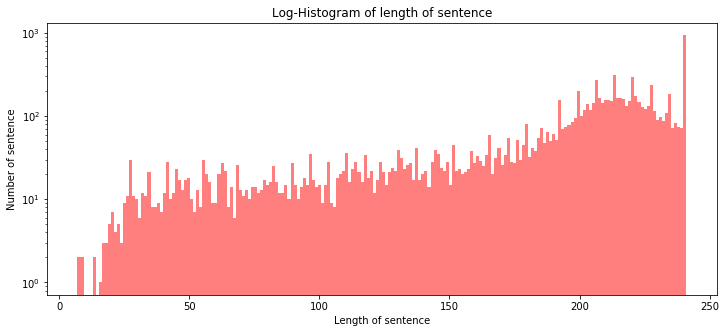

In [252]:
sentence_len = data.sentence.apply(len)
plt.figure(figsize=(12, 5))
plt.hist(sentence_len, bins=200, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('Log-Histogram of length of sentence')
# 그래프 x 축 라벨
plt.xlabel('Length of sentence')
# 그래프 y 축 라벨
plt.ylabel('Number of sentence')

In [237]:
print('문장 길이 최대 값: {}'.format(np.max(sentence_len)))
print('문장 길이 최소 값: {}'.format(np.min(sentence_len)))
print('문장 길이 평균 값: {:.2f}'.format(np.mean(sentence_len)))
print('문장 길이 표준편차: {:.2f}'.format(np.std(sentence_len)))
print('문장 길이 중간 값: {}'.format(np.median(sentence_len)))

# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('문장 길이 제 1 사분위: {}'.format(np.percentile(sentence_len, 25)))
print('문장 길이 제 3 사분위: {}'.format(np.percentile(sentence_len, 75)))

문장 길이 최대 값: 763
문장 길이 최소 값: 9
문장 길이 평균 값: 210.25
문장 길이 표준편차: 57.51
문장 길이 중간 값: 227.0
문장 길이 제 1 사분위: 211.0
문장 길이 제 3 사분위: 241.0


### WordCloud

In [245]:
cloud = WordCloud(width=800, height=600, font_path=FONT_PATH).generate(" ".join(data['sentence']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

NameError: name 'FONT_PATH' is not defined

### 전처리
- html tag 삭제
- 문장 길이 3사분위인 241 글자 이후는 자르기
- 영어 소문자로 변경
- 영어, 숫자, 한글, 띄어쓰기만 남기기
- 띄어쓰기 2칸 이상은 1칸으로 변경
- strip : 앞뒤 공백 제거
- 비어있는 데이터(np.nan) -> ''으로 변경

In [248]:
a = "12345678"
if len(a) > 5:
    a = a[:5]
a

'12345'

In [249]:
def preprocess(x):
    # html tag 삭제
    x = BeautifulSoup(x, "html.parser").get_text()
    
#     maxLength = 241
#     if len(x) > maxLength:
#         x = x[:maxLength]
    
    # 소문자로 변경
    x = x.lower()
    
    # 영어, 숫자, 한글, 띄어쓰기만 남기기
    x = re.sub('[^가-힣\sa-zA-Z0-9]', '', x)
    
    # 띄어쓰기 1개로 줄이기
    x = re.sub('\s{2,}', ' ', x)
    
    # 
    
    # 앞뒤 공백 제거
    x = x.strip()
    
    return x

In [250]:
data.sentence = data.sentence.apply(preprocess)

In [251]:
data.head(10)

,label,sentence
0,1,todo 리스트를 1달간 사용해본 후기 왜 todo 리스트를 사용했나요 위 질문에 ...
1,0,양평 블룸비스타 콩순이 패밀리룸이 궁금하신분에게 드리는 후기 늦은 여름 휴가로 양평...
2,1,javascript js 자바스크립트 문자열 메소드 javascript 문자열 메소...
3,0,우리 시장에는 어떤 교육이 필요할까요 1 시장적합형 교육과 기술적합형 교육 며칠전 ...
4,0,저 많은 국민은행 앱들은 대체 다 어디다 쓰는 걸까 대략 정리 구글플래이 스토어에서...
5,1,java java 8 람다 표현식과 주의 사항 안녕하세요 오늘부터는 java8에 관...
6,1,cache 16장 트랜잭션과 락 2차 캐시 현업에서 주문 결제 등등 민감한 데이터를...
7,1,swift lets swift 2019에 다녀왔습니다 1년에 한번 있는 ios개발자...
8,0,건설 현장 안전관리를 위한 iot 기반의 위험구역 경보 시스템 마침 지금 개발하는 ...
9,0,kstartup 그랜드챌린지ksgc 오픈하우스 행사와 참가기업 kstartup gr...


In [243]:
data.sentence[2]

'javascript js 자바스크립트 문자열 메소드 javascript 문자열 메소드 string method 자바스크립트에서 자주 쓰이는 문자열 메소드를 정리자바스크립트는 문자열을 배열과 같이 사용할 수 있기 때문에배열과 중복되는 메소드는 제외하고 나머지만 정리 charcodeat 주어진 인덱스에 대한 utf16 코드를 나타내는 0부터 65535 사이의 정수를 반환인자 index 0'

### 전처리 결과 확인

(-0.5, 799.5, 599.5, -0.5)

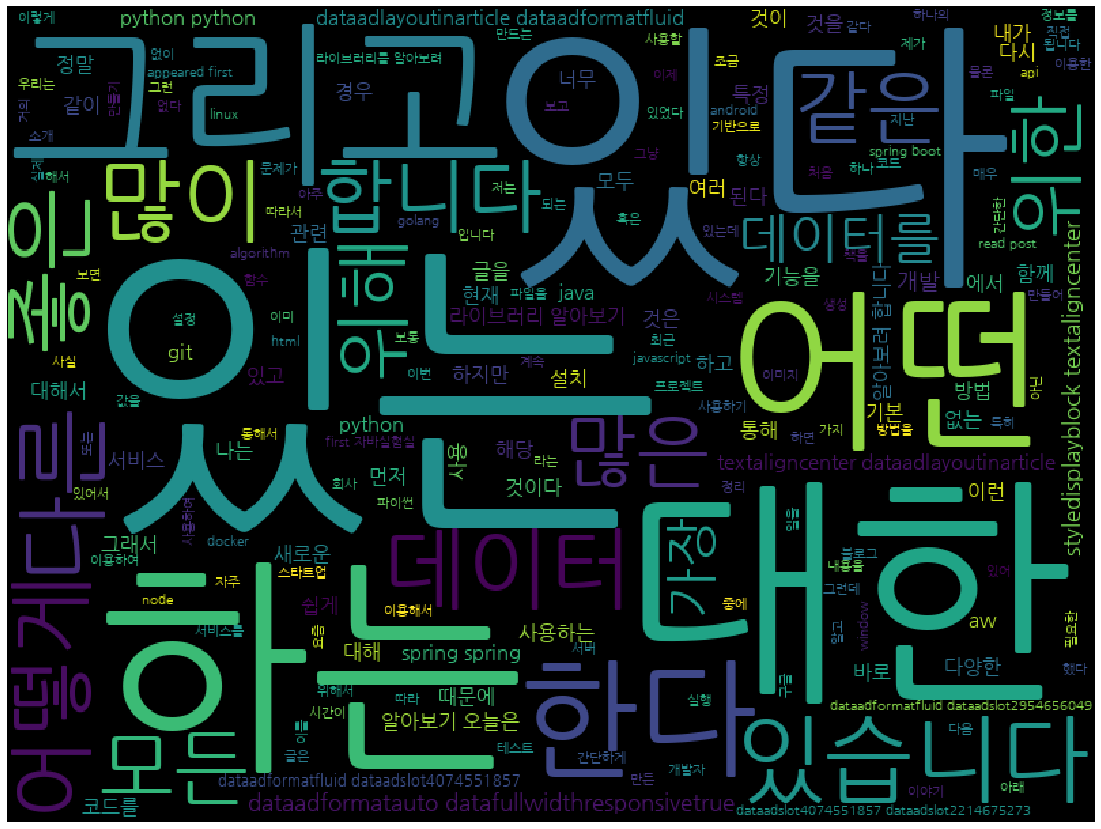

In [247]:
cloud = WordCloud(width=800, height=600, font_path=FONT_PATH).generate(" ".join(data['sentence']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')